In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# real all the words
words = open('/kaggle/input/namestxt/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/form integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3
def build_dataset(words):

    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], [] # X: inputs, Y: labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append (rolling window)
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of embedding of character vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(24)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01# step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # print once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 22.1142
  10000/ 200000: 3.2240
  20000/ 200000: 2.1902
  30000/ 200000: 2.5724
  40000/ 200000: 2.4038
  50000/ 200000: 2.4163
  60000/ 200000: 2.2027
  70000/ 200000: 2.2068
  80000/ 200000: 2.3728
  90000/ 200000: 2.0483
 100000/ 200000: 2.0201
 110000/ 200000: 2.0065
 120000/ 200000: 1.8766
 130000/ 200000: 2.5013
 140000/ 200000: 2.1540
 150000/ 200000: 2.3089
 160000/ 200000: 1.9199
 170000/ 200000: 2.1390
 180000/ 200000: 2.3719
 190000/ 200000: 2.2413


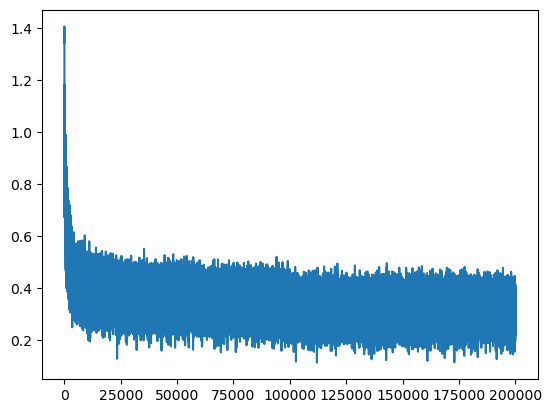

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    # foward pass
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.1088151931762695
val 2.1464428901672363


context manager with torch.no_grad

In [9]:
# sample from the model 
g = torch.Generator().manual_seed(24 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # intialize will all ...
    
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context windows and track the samples 
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
        
    print(''.join(itos[i] for i in out)) # decode and print the generated word

eulah.
rier.
zehannlee.
willa.
khilon.
emira.
hah.
ava.
adi.
stan.
luchukwu.
rous.
ther.
streckon.
beck.
liya.
melrah.
jatcy.
kailynnlie.
camelynne.


## fixing the initial loss

If you look at the training and 0th iteration, loss is way too high and it tells us that the initialization is all messed up. We do not except 22, we expect much lower loss.

there are 27 characters that could come next and at initialization the probability distribution we expect is uniform and the probability for every character should be roughy 1/27.0 and the loss we expect is:

In [10]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

which is much much lower than 22.0. The problem is that at initialization the network is very confidently wrong and that's why it records a very high loss.

In [11]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0]) # all zeros
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

In [12]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 5.0, 0.0]) # assigning high probability by chance to the correct label at initialization
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# low loss

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

In [13]:
# 4-dimensional example of the issue
logits = torch.tensor([0.0, 5.0, 0.0, 0.0]) # high value at some other dimension of logit
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

# high loss

(tensor([0., 5., 0., 0.]),
 tensor([0.0066, 0.9802, 0.0066, 0.0066]),
 tensor(5.0200))

We do not want it to be a +ve or -ve number. We just want it to be 0.0. When we debug the logits at initiliazation, we see that they take extreme values and that's what creating a fake confidence in the incorrect answers and makes the loss high. So these logits should be much much closer to 0.

In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of embedding of character vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(24)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we are not using 0 because we want some entropy for symmetry breaking
b2 = torch.randn(vocab_size, generator=g) * 0 # we do not want any bias at initialization 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [6]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01# step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # print once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2861
  10000/ 200000: 2.4128
  20000/ 200000: 1.8950
  30000/ 200000: 2.2407
  40000/ 200000: 2.2639
  50000/ 200000: 2.1985
  60000/ 200000: 1.9760
  70000/ 200000: 2.0981
  80000/ 200000: 2.2932
  90000/ 200000: 1.8791
 100000/ 200000: 1.8337
 110000/ 200000: 1.9062
 120000/ 200000: 1.9234
 130000/ 200000: 2.3841
 140000/ 200000: 2.1288
 150000/ 200000: 2.3600
 160000/ 200000: 1.8485
 170000/ 200000: 2.1254
 180000/ 200000: 2.2340
 190000/ 200000: 2.0705


now the initial comes out to be 3.30

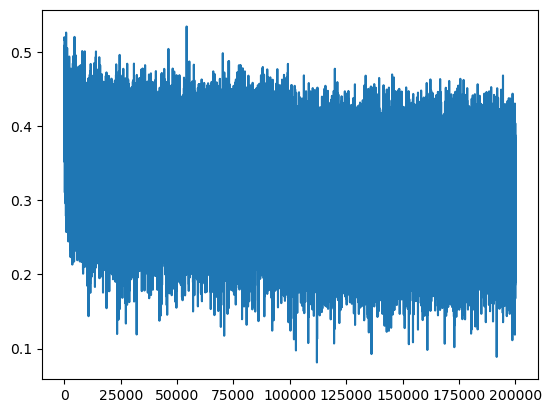

In [7]:
plt.plot(lossi)

and this does not have a hockey stick visual because earlier the network was spending a few thousand iterations just squashing down the weights and now we took away this easy part. we are "actually" training the neural net.

In [8]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    # foward pass
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0375847816467285
val 2.10479998588562


we get an improved loss as we are now spending more iterations optimizing the neural net "actually" instead of spending these iterations to squash down the weights

## fixing the saturated tanh

If we take a look at the h you'll see a lot of 1.0s and the torch.tanh() is a squashing function and it takes the activations and squashed them into [-1, 1] and does it smoothly

In [40]:
h

tensor([[-0.9996, -0.7890, -0.9991,  ..., -1.0000, -0.9615, -1.0000],
        [ 0.0684, -0.9879, -0.9999,  ...,  0.6025, -0.6737, -0.9998],
        [ 0.9996,  0.9999, -0.8188,  ...,  1.0000,  0.5584, -0.6413],
        ...,
        [-1.0000,  0.9996, -1.0000,  ...,  1.0000,  1.0000, -1.0000],
        [-1.0000,  0.3247,  0.9983,  ..., -1.0000,  0.9802, -0.9997],
        [ 1.0000, -1.0000,  0.9964,  ..., -0.9976, -0.9410, -1.0000]],
       grad_fn=<TanhBackward0>)

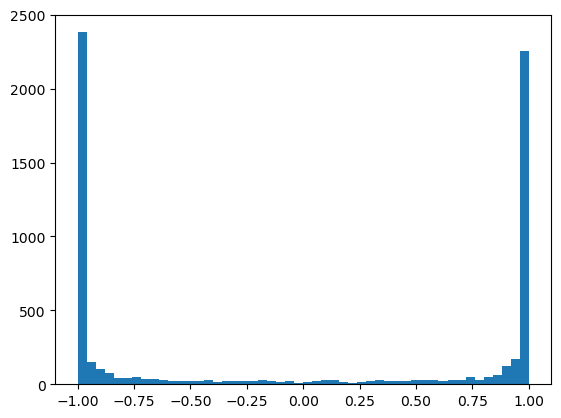

In [41]:
plt.hist(h.view(-1).tolist(), 50);

as you can see these activations are taking mostly 1.0 and -1.0 and this tanh is very very active

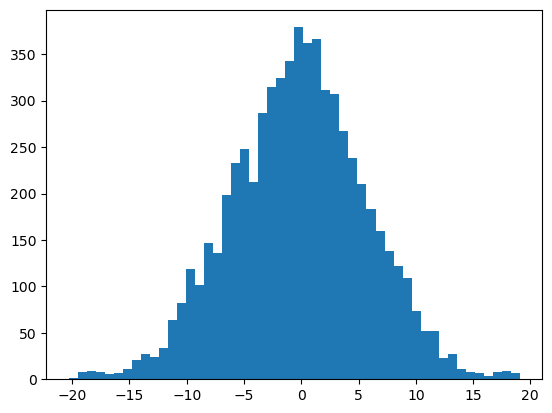

In [42]:
plt.hist(hpreact.view(-1).tolist(), 50);

hpreact is taking very extreme values

when we do backprop on tanh `self.grad += (1 - t ** 2) * out.grad` REMEMBER MICROGRAD If the value of t = 1.0 or t = -1.0 then the gradient becomes 0.0 even if there is out.grad. We're basically killing the gradient. In simple terms, even if we change the weights of the inputs, tanh is not going to have an impact on the loss as we're already in the flat region of the tanh.

and when t = 0 out.grad just passes through (inactive unit)

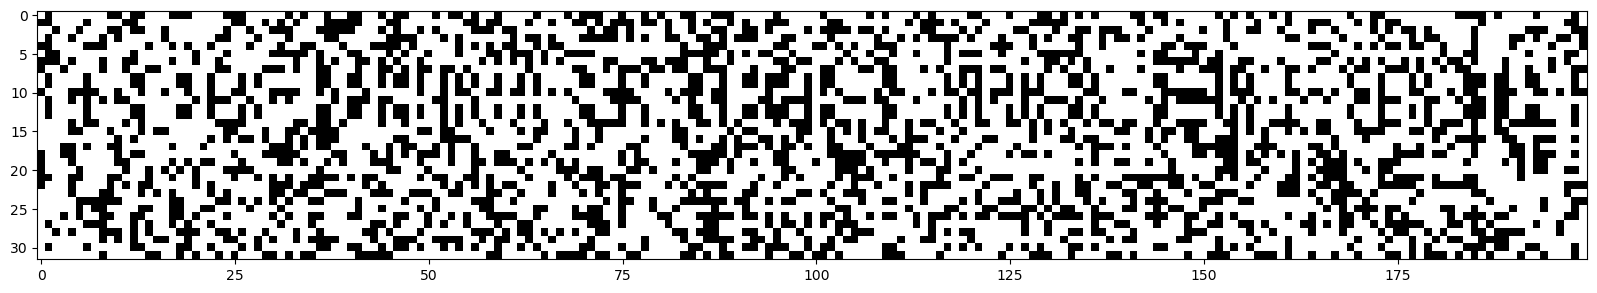

In [43]:
# see how many values of h are in flat region of tanh
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white if true

# we can see there are many many whites and this tells us that all these tanh neurons are very very active and in flat tail
# and in all these cases the backward gradient will get destroyed

DEAD NEURON - If any one of these 200 neurons if an entire column was white and that no single example is activates that tanh and this neuron never learns and fires a completely 1.0 or -1.0

a lot of other activation functions have this like sigmoid (a squashing function), ReLU (a completely flat function), ELU

this can happen by chance at initialization and also can happen at optimization when the your learning rate is so high that these nuerons gets knocked out and no example ever activates

leakyReLU does not suffer from this as it does not flat region

In our case even if you do not have a dead neuron, we still have a lots of whites and it is not ideal espcially at intiliazation

to address this we're adding a bit into W1 and b1

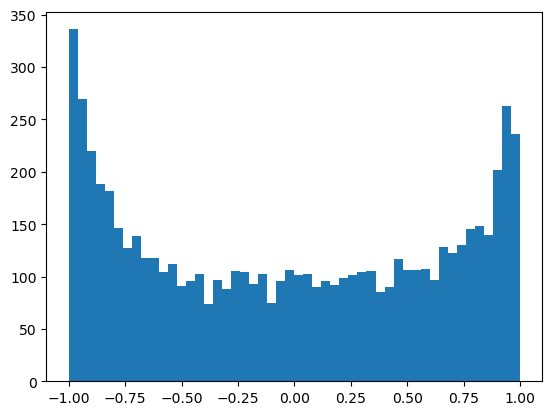

In [51]:
plt.hist(h.view(-1).tolist(), 50);

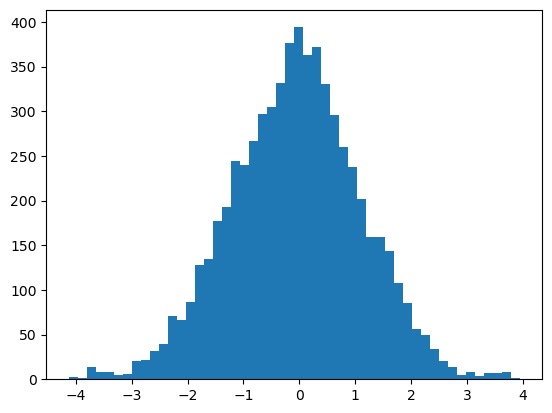

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50);

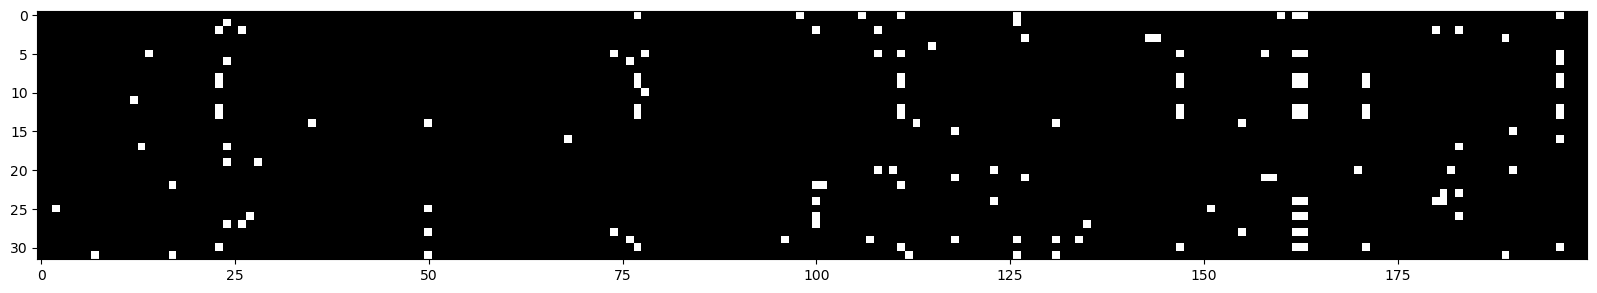

In [53]:
# see how many values of h are in flat region of tanh
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white if true

# we can see there are many many whites and this tells us that all these tanh neurons are very very active and in flat tail
# and in all these cases the backward gradient will get destroyed

This is a nice distribution and it is what it should be at initialization

now we're running a full optimization

In [67]:
# loss log

# original:
# train 2.10
# val 2.14

# fix softmax confidently wrong:
# train 2.06
# val 2.13

# fix tanh layer too saturated at init:
# train 2.03
# val 2.10

# use semi-principled "kaiming init" instead of hacy init:
# train 2.03
# val 2.10

# add a batch norm layer
# train 2.07
# val 2.11

INITIALIZATION IS VERY VERY IMPORTANT

The deeper our network is, the less forgiving it is to some of these errors

## calculating the init scale: "Kaiming init"

Where do I come up with this magic numbers like 0.2, 0.01, etc. and how am I suppose to set these when we have a large neural nwetwork with lots and lots of layers

tensor(-0.0097) tensor(0.9901)
tensor(-0.0079) tensor(3.2013)


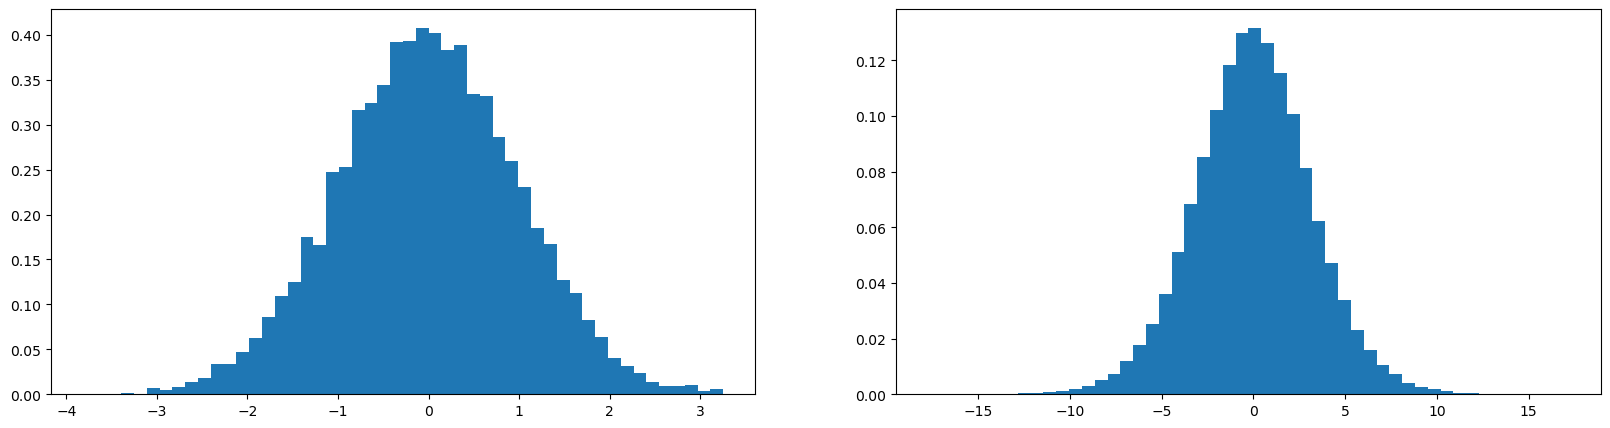

In [70]:
# std is just the spread of the guassian

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

You can see the x is a normal gaussian (mean 0 and std 1) but when we multiple it with w, the mean stays the same but the std increases. We want our network to have roughly same activation. So gaussian. How do we preserve the distribution?

tensor(-0.0022) tensor(0.9997)
tensor(0.0242) tensor(15.7355)


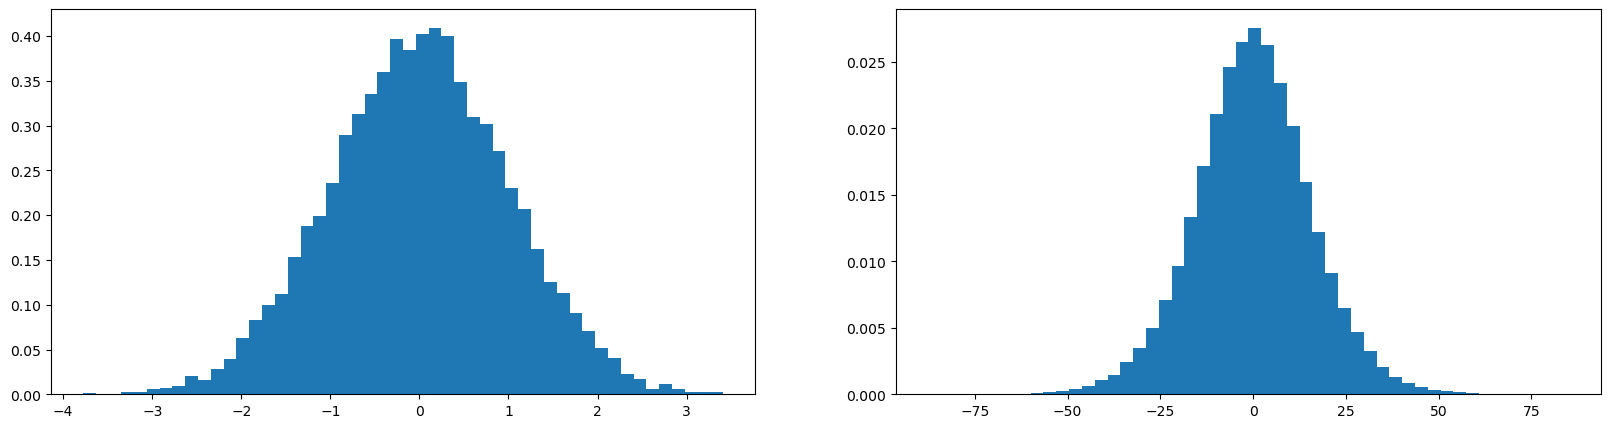

In [71]:
# gaussian grows in std

x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

tensor(-0.0024) tensor(0.9797)
tensor(0.0043) tensor(0.6167)


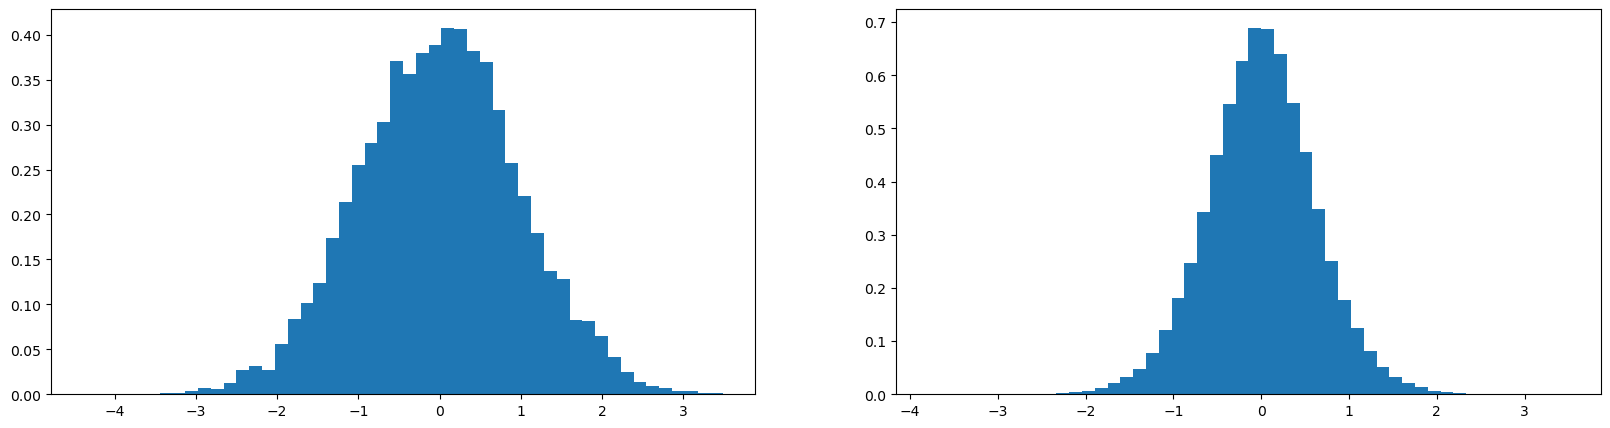

In [72]:
# gaussian shrinks in std

x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

What do I multiple here to exactly preserve the std to be 1.0?

tensor(-0.0017) tensor(0.9820)
tensor(0.0004) tensor(0.9880)


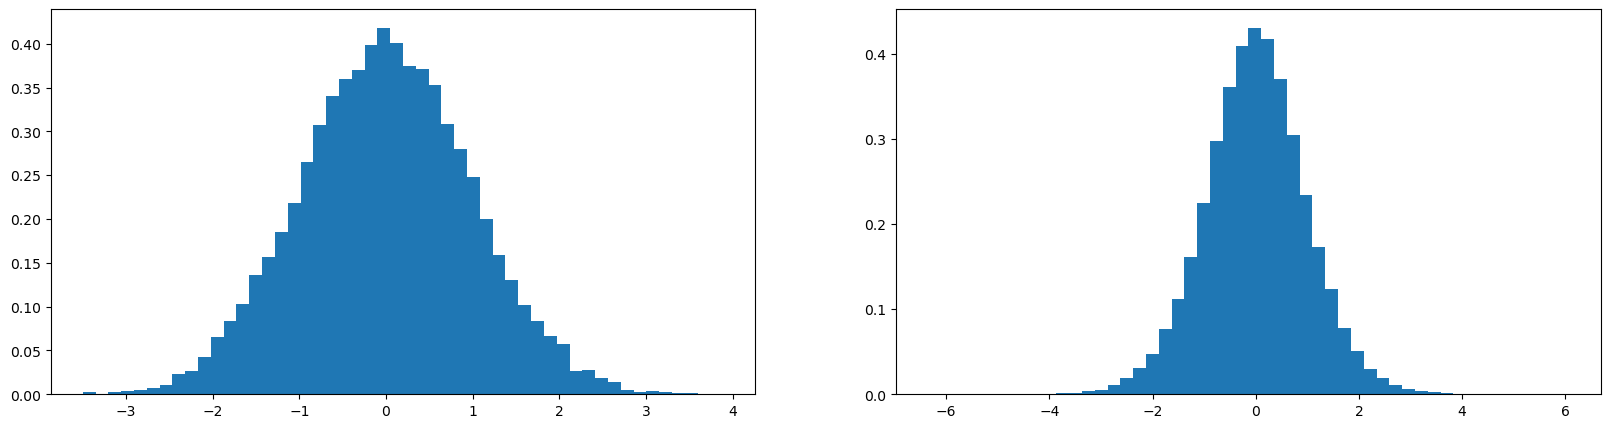

In [9]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10 ** 0.5 # square-root of the fan-in
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

We want the activations to be well behaved and they do not expand to infinity or shrink down to zero. There is a paper by Kaiming He. In this paper they studied that since you're using a squashing fucntion like ReLU or PReLU, all the negative numbers are simply clamped to 0.0 (so +ve numbers are passed through but everything else is set to 0.0) and so basically you're throwing away half of the distribution, they find in their analysis that you need to compensate for that with a gain.

They say that the result is a zer0-mean gaussian whose standard deviation is square-root of 2/fan-in. They'd to add this 2 because they are using ReLU which clamps half of the distribution to zero.

They also studied that not only in the forward pass but also in the backward pass the parameters needs to be well-behaved.

We have this implemented in PyTorch [kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html)

We need to pass mode and the best value seems to be the default one ('fan_in'). We also need to pass nonlinearity that we're using and the gain is calculated based on that.

Since these squashing functions squeezes the weights, in order to fight the squeezing, we need to boost the weights a bit so that we normalize everything back to unit std.

Modern innovations such as better optimizers than SGD like Adam, normalization layers such as batch normalization, and residual networks has made nn very stable and we do not need to initialize them perfectly.

Andrej typically initializes with square-root of fan-in.

In [10]:
(5/3) / (30**0.5) # this is the std we want

0.3042903097250923

So we're multiplying by 0.3 instead of multiplying by 0.2

In [11]:
# MLP revisited
n_embd = 10 # the dimensionality of embedding of character vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(24)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we are not using 0 because we want some entropy for symmetry breaking
b2 = torch.randn(vocab_size, generator=g) * 0 # we do not want any bias at initialization 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

11897


In [12]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01# step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # print once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2877
  10000/ 200000: 2.3632
  20000/ 200000: 1.9473
  30000/ 200000: 2.3145
  40000/ 200000: 2.2479
  50000/ 200000: 2.2607
  60000/ 200000: 1.9705
  70000/ 200000: 2.1345
  80000/ 200000: 2.2384
  90000/ 200000: 1.8992
 100000/ 200000: 1.8287
 110000/ 200000: 1.8770
 120000/ 200000: 1.8626
 130000/ 200000: 2.3532
 140000/ 200000: 2.0955
 150000/ 200000: 2.4471
 160000/ 200000: 1.7971
 170000/ 200000: 2.0747
 180000/ 200000: 2.1993
 190000/ 200000: 2.1187


In [13]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    # foward pass
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.038682460784912
val 2.108527898788452


We roughly end up in the same spot. There is a lil bit of difference but it is the randomness that might have caused this.

## batch normalization

It made possible to train deep neural networks quite reliably.

Here we discussed how we want the `hpreact` to be roughly gaussian atleast at initialization. So the concept is to just normalize the hidden states to be guassian.

We need these to be gaussian at initialization and not always. We'd like to have this distribution moved around and let backprop tell us how this distribution is moved around.

So to do scale and shift, we need some batch normalization gain and a offset bias. So at initialization we will have a gaussian and then the backprop will change the bngain and bnbias and trained.

It is common to take a linear layer and append a batchnorm later right after it to control the scales of these activations at point in time and it significantly stabilizes the training.

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of embedding of character vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(24)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
# b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01 # we are not using 0 because we want some entropy for symmetry breaking
b2 = torch.randn(vocab_size, generator=g) * 0 # we do not want any bias at initialization 

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12297


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm layer 
    # -----------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # momentum=0.001
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -----------------------------------------------------------
    # non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01# step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    # print once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.2827
  10000/ 200000: 2.3007
  20000/ 200000: 1.8513
  30000/ 200000: 2.3569
  40000/ 200000: 2.3849
  50000/ 200000: 2.1578
  60000/ 200000: 2.1713
  70000/ 200000: 2.1161
  80000/ 200000: 2.1422
  90000/ 200000: 1.8943
 100000/ 200000: 1.9235
 110000/ 200000: 1.9212
 120000/ 200000: 1.8981
 130000/ 200000: 2.4678
 140000/ 200000: 2.1539
 150000/ 200000: 2.4126
 160000/ 200000: 1.8281
 170000/ 200000: 2.1059
 180000/ 200000: 2.3661
 190000/ 200000: 2.1184


In fact, we do not expect a great improvement in the performance of the model with batch normalization.
This is simply because our MLP is too simple for batch normalization to have a big impact.

In [11]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    # foward pass
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / (hpreact.std(0, keepdim=True)) + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.070723533630371
val 2.1105470657348633


batch normalization layer happens to have this regularizing effect

How is this suppose to work in production where we would input one example and predict the next character? the batch normalization layer expects a batch as input as it needs to calculate mean and std.

In [8]:
# calibrate the batch norm at the end of training

with torch.no_grad(): # none of this we will call .backward() on
    
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [9]:
bnmean

tensor([[-6.5944e-01, -2.9947e-01, -7.1457e-01, -1.7139e-01, -9.2544e-01,
          5.3442e-02,  2.9212e-01, -1.5173e+00, -3.8811e-01,  2.8441e-01,
          1.4366e+00,  6.9686e-02,  1.0817e+00,  6.1798e-01,  8.8838e-01,
          4.2513e-01, -8.0853e-01,  5.5125e-01, -5.1427e-01,  5.0811e-01,
          2.6717e-01, -9.1732e-01,  2.1161e-01,  6.7142e-01,  1.9207e-01,
         -3.2095e-01, -8.1113e-01, -8.9058e-01,  1.0304e+00,  1.5455e-01,
         -3.5410e-01, -6.2581e-02,  9.1345e-02, -1.3711e-01, -1.8208e-01,
         -8.4670e-01, -1.2080e+00,  5.1187e-01, -3.8165e-01,  5.4520e-02,
         -2.1343e-01,  4.4519e-01,  3.5612e-01, -1.2744e+00, -5.1064e-01,
          3.4148e-01, -2.2247e-01, -3.5319e-01, -1.0983e+00,  8.4810e-01,
         -8.2401e-01,  1.4281e+00, -4.5372e-01,  8.3994e-01,  3.5542e-01,
          1.9194e-01, -1.3960e-01, -5.2565e-01, -7.3588e-01, -5.2459e-02,
         -4.8285e-01, -3.1131e-01, -1.8497e-01,  1.0889e+00, -6.7998e-01,
          2.0338e-01, -2.0063e+00, -4.

In [10]:
bnmean_running

tensor([[-6.4525e-01, -2.9713e-01, -7.0986e-01, -1.8755e-01, -9.1573e-01,
          5.1350e-02,  2.8184e-01, -1.5215e+00, -3.7931e-01,  2.8338e-01,
          1.4304e+00,  6.9046e-02,  1.0918e+00,  6.1214e-01,  8.8089e-01,
          4.2850e-01, -7.7933e-01,  5.2724e-01, -5.1250e-01,  5.0463e-01,
          2.8188e-01, -9.0692e-01,  2.1124e-01,  6.6442e-01,  1.7491e-01,
         -3.3176e-01, -8.1112e-01, -8.7888e-01,  1.0335e+00,  1.6105e-01,
         -3.4517e-01, -5.6912e-02,  8.9613e-02, -1.3391e-01, -1.7937e-01,
         -8.3825e-01, -1.1956e+00,  4.9949e-01, -3.7791e-01,  4.7447e-02,
         -1.9856e-01,  4.4758e-01,  3.5016e-01, -1.2591e+00, -5.2163e-01,
          3.4530e-01, -2.2819e-01, -3.5432e-01, -1.0890e+00,  8.3835e-01,
         -8.1252e-01,  1.4344e+00, -4.4289e-01,  8.5014e-01,  3.4326e-01,
          1.8369e-01, -1.5806e-01, -5.1858e-01, -7.4852e-01, -4.8906e-02,
         -4.6678e-01, -3.1232e-01, -1.7679e-01,  1.0721e+00, -6.7568e-01,
          2.1700e-01, -1.9867e+00, -4.

we are now using the fixed bnmean and bnstd

we are hoping that bnmean_running and bnstd_running will be roughly similar to bnmean and bnstd

and we do not need this second stage of explicit calibration after training as we put this on the side of the training

you can see `bnmean` and `bnmean_running` are not identical but are very close

same is the case with `bnstd` and `bnstd_running`

In [9]:
@torch.no_grad() # this decorator disables gradient tracking 
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    # foward pass
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # concatenate into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # (N, n_hidden)
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
    h = torch.tanh(hpreact) # (N, vocab_size)
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, y) # loss function
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.070723533630371
val 2.110529661178589


we are going to estimate the bnmean and bnstd during training on the side and do not need any gradients for these

batch normalization layer has its own bias and so we do not need a bias a layer before it because that bias will be substracted anyway

## real example: resnet50 walkthrough

## summary of the lecture

1. importance of understanding the activations and gradients and their statistics in the nn
2. we looked at the distributions at the output layer and saw that if we you have too confident mispredictions because the activations are too messed up at the last layer you can end up with these hockey stick losses. If you fix this you get a better loss at the end of the training because your nn is not doing wasteful work
3. we need roughly gaussian activations throughout the neural net
4. normalization layers
5. batchnorm layer (try to avoid it as much as possible)

## PyTorch-ifying the code

In [8]:
# Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momemtum=0.1):
        self.eps = eps
        self.momemtum = momemtum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momemtum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momemtum) * self.running_mean + self.momemtum * xmean
                self.running_var = (1 - self.momemtum) * self.running_var + self.momemtum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

46497


In [10]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2989


## viz #1: forward pass activation statistics

layer 1 (      Tanh): mean -0.02, std 0.76, saturated: 21.03%
layer 3 (      Tanh): mean +0.00, std 0.68, saturated: 8.38%
layer 5 (      Tanh): mean -0.00, std 0.67, saturated: 7.41%
layer 7 (      Tanh): mean -0.03, std 0.66, saturated: 5.81%
layer 9 (      Tanh): mean -0.03, std 0.66, saturated: 6.59%


Text(0.5, 1.0, 'Activation Distribution')

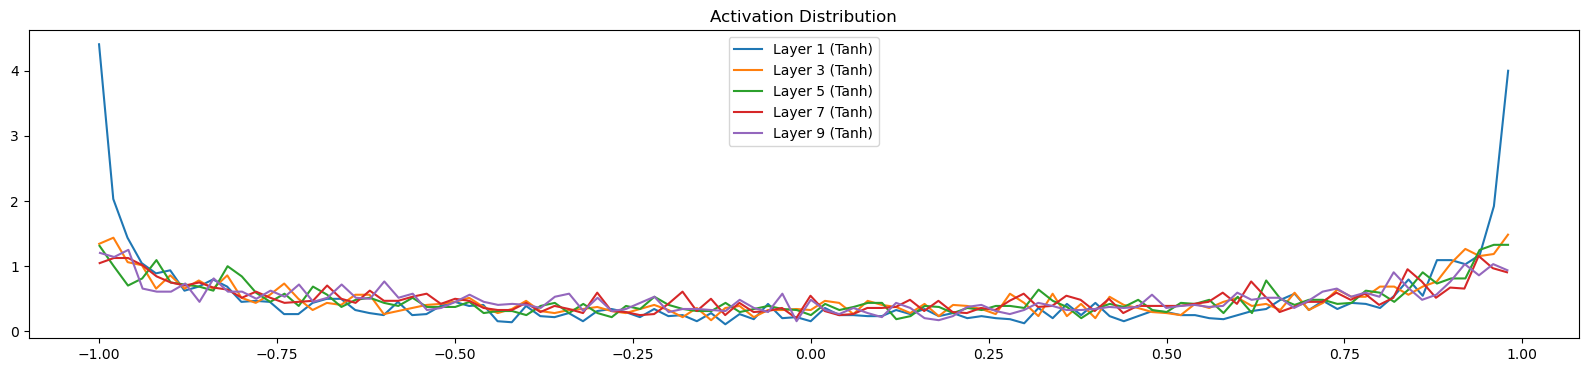

In [11]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

## viz #2: backward pass gradient statistics

## the fully linear case of no non-linearities

## viz #3: parameter activation and gradient statistics

## viz #4: update:data ratio over time

## bringing back batchnorm, looking at the visualizations

In [12]:
# Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momemtum=0.1):
        self.eps = eps
        self.momemtum = momemtum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momemtum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momemtum) * self.running_mean + self.momemtum * xmean
                self.running_var = (1 - self.momemtum) * self.running_var + self.momemtum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [13]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # foward pass
    emb = C[Xb] # embed the chracters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER DEBUG: would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward() 

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    break # AFTER DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 3.69%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.66%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.78%
layer 14 (      Tanh): mean -0.00, std 0.64, saturated: 2.72%


Text(0.5, 1.0, 'Activation Distribution')

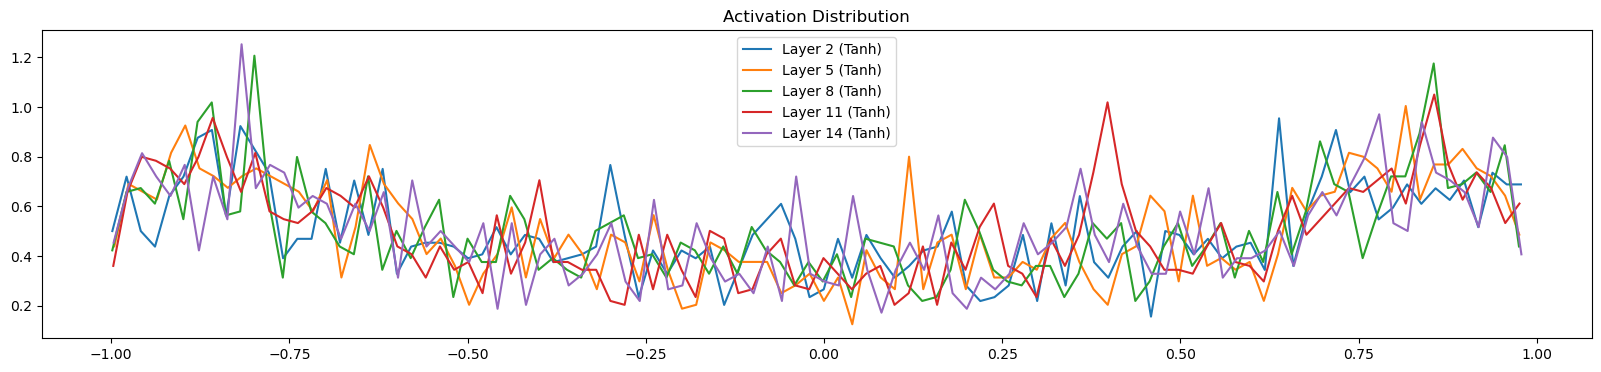

In [14]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'Layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('Activation Distribution')

## summary of the lecture

1. intro to batchnorm that help stabilize the training of a deep nn
2. how the batchnorm works and used in the nn
3. pytorch-ify the code
4. diagnostic tools used to understand if the nn is in a good state